In [2]:
%matplotlib inline
import math
import time
import pandas as pd
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.preprocessing import normalize
import seaborn as sn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# normalization
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_train_norm = df_train.copy()
df_train_norm['Distance_To_Hydrology'] = (df_train_norm['Horizontal_Distance_To_Hydrology']**2 + df_train_norm['Vertical_Distance_To_Hydrology']**2)**(1/2)
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)
df_train_norm['log_Elevation'] = ((df_train_norm['Elevation']**1.5)+1).apply(np.log)
df_train_norm.drop(columns=['Elevation','Horizontal_Distance_To_Roadways'])


,Id,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Distance_To_Hydrology,log_Horizontal_Distance_To_Roadways,log_Elevation
0,1,0.008102,0.000477,0.040989,0.000000,0.035111,0.036858,0.023513,0.997552,1,...,0,0,0,0,0,0,5,258.000000,6.236370,11.792598
1,2,0.008976,0.000321,0.033980,-0.000962,0.035262,0.037666,0.024203,0.997755,1,...,0,0,0,0,0,0,5,212.084889,5.968708,11.789127
2,3,0.022641,0.001466,0.043653,0.010587,0.038115,0.038766,0.021989,0.997010,1,...,0,0,0,0,0,0,2,275.769832,8.064951,11.908210
3,4,0.024883,0.002890,0.038850,0.018943,0.038208,0.038208,0.019586,0.997096,1,...,0,0,0,0,0,0,2,269.235956,8.036250,11.898012
4,5,0.007277,0.000323,0.024740,-0.000162,0.035574,0.037838,0.024255,0.998023,1,...,0,0,0,0,0,0,5,153.003268,5.971262,11.792020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,0.175948,0.016654,0.186809,0.005068,0.123091,0.181740,0.154950,0.928252,0,...,0,0,0,0,0,0,3,258.094944,6.493754,11.798941
15116,15117,0.079296,0.012451,0.414829,0.127791,0.163179,0.144830,0.059636,0.868323,0,...,0,0,0,0,0,0,3,662.354890,6.428105,11.796637
15117,15118,0.103008,0.019218,0.280582,0.089940,0.192180,0.169118,0.063804,0.912469,0,...,0,0,0,0,0,0,3,383.293621,5.817111,11.731269
15118,15119,0.160860,0.026971,0.209985,0.097287,0.220581,0.228287,0.114625,0.897735,0,...,0,0,0,0,0,0,3,240.260276,5.493061,11.728257


In [4]:
kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
np.set_printoptions(precision=5)
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False):
    X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    print('\nModel:',type(model).__name__)
    print('\tcv acc:', round(results.mean(),4))
    print('\tsplit acc:', round(acc,4))
    print('\ttime taken:', round(end-start, 4))
    if display:
        matrix = cm(y_val, pred)
        print('\t', matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Id','Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

In [ ]:
# This creates a dataset for EDA manipulation
df_eda = df_train_norm.copy()

# This creates 2 new columns that summarize the Wilderness Area and Soil Type columns for ease of visualization
df_eda['Wilderness_Area'] = df_eda.iloc[:,11:15].idxmax(axis=1).str.replace('Wilderness_Area','')
df_eda['Soil_Type'] = df_eda.iloc[:,16:55].idxmax(axis=1).str.replace('Soil_Type','')

In [ ]:
df_eda['Wilderness_Areas'] = df_eda['Wilderness_Area1'] + df_eda['Wilderness_Area2'] + df_eda['Wilderness_Area3'] + df_eda['Wilderness_Area4']

plt.figure()
df_one = df_eda[df_eda['Cover_Type'] == 1]
sn.histplot(data=df_one, x='Elevation')

plt.figure()
df_two = df_eda[df_eda['Cover_Type'] == 2]
sn.histplot(data=df_two, x='Elevation')

In [ ]:
from sklearn.feature_selection import SelectKBest

df_train_sp = df_train_norm[(df_train_norm['Cover_Type'] == 2) | (df_train_norm['Cover_Type'] == 1)]
X , Y = df_train_sp.drop(columns=['Id','Cover_Type']).to_numpy(), df_train_sp.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
X_new = SelectKBest(k='all').fit(X_train,y_train)
scores = X_new.scores_
ind_sc = np.argsort(scores)[::-1]
j = 0
for i in range(len(ind_sc)):
    if np.isnan(scores[ind_sc[i]]):
        continue
    print(str(j) + ". " + df_train_sp.columns[ind_sc[i] + 1] + ": " + str(scores[ind_sc[i]]))
    j+=1

In [ ]:
df_train_sp.columns

### Kevin's code: 

In [11]:
def pipeline(df, version=0):
    df_n = df.copy()
    df_n = df_n.astype({c:'bool' for c in df_n.columns if "Soil_Type" in c or "Wilderness_Area" in c})
    if version >= 1: 
        col_normalize = ['Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                     'Horizontal_Distance_To_Roadways']
        df_n['log_Horizontal_Distance_To_Roadways'] = np.log(df_n['Horizontal_Distance_To_Roadways']+1)
        df_n['log_Horizontal_Distance_To_Fire_Points'] = np.log(df_n['Horizontal_Distance_To_Fire_Points']+1)
        df_n[col_normalize] = normalize(df_n[col_normalize])
        df_n.drop(columns=['Soil_Type7'],inplace=True)
    if version >= 2: # 0.8964947089947091
        df_n['sq_Elevation'] = np.power(df['Elevation'],1.5)
        df_n.drop(columns='Aspect',inplace=True)
        df_n['norm_aspect'] = df.Aspect.map(lambda x: x-180 if x > 180 else x+180) # np.abs(df.Aspect - 180)
    if version >= 3: # 0.9104497354497356
        df_n['Vertical_Distance_To_Hydrology'] = np.abs(df_n.Vertical_Distance_To_Hydrology)
        df_n['E-VH'] = df.Elevation - df.Vertical_Distance_To_Hydrology * .9 
        df_n['E-HH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * .5
        
        
        df_n['F+R'] = (df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Roadways) ** 2
        df_n['F+H'] = (df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Hydrology) ** 0.3
        df_n['H+R'] = (df.Horizontal_Distance_To_Hydrology + df.Horizontal_Distance_To_Roadways)
        
        df_n['abs_H-R'] = (np.abs(df.Horizontal_Distance_To_Hydrology - df.Horizontal_Distance_To_Roadways)) 
        df_n['abs_H-F'] = (np.abs(df.Horizontal_Distance_To_Hydrology - df.Horizontal_Distance_To_Fire_Points)) 
        df_n['abs_F-R'] = (np.abs(df.Horizontal_Distance_To_Fire_Points - df.Horizontal_Distance_To_Roadways)) 
    return df_n

def soils(model):
    df_train_norm_copy = df_train_norm.copy()
    soils = ['Soil_Type' + str(i) for i in range(1,41) if i != 7]
    one_ind = list(df_train_norm_copy.columns).index('Soil_Type1')
    fort_ind = list(df_train_norm_copy.columns).index('Soil_Type40')
    df_train_norm_copy['Soil_Type'] = (df_train_norm_copy.iloc[:, one_ind:fort_ind] == 1).idxmax(1).str.replace('Soil_Type','').astype(float)
    df_train_norm_copy.drop(columns=soils, inplace=True)
    return df_train_norm_copy

def wa(model):
    df_train_norm_copy = df_train_norm.copy()
    was = ['Wilderness_Area' + str(i) for i in range(1,5)]
    one_ind = list(df_train_norm_copy.columns).index('Wilderness_Area1')
    four_ind = list(df_train_norm_copy.columns).index('Wilderness_Area4')
    df_train_norm_copy['Wilderness_Area'] = (df_train_norm_copy.iloc[:, one_ind:four_ind] == 1).idxmax(1).str.replace('Wilderness_Area','').astype(float)
    df_train_norm_copy.drop(columns=was, inplace=True)
    return df_train_norm_copy

def submit(model,version):
    global df_train
    df_train_c = pipeline(df_train.copy(),version)
    df_submit = pipeline(df_test.copy(),version)
    X, Y = df_train_c.drop(columns=['Cover_Type']).to_numpy(), df_train_c.Cover_Type.to_numpy()
    model.fit(X, Y)
    pred = model.predict(df_submit.to_numpy())
    final_df = df_test.copy()
    final_df['Cover_Type'] = pred
    return final_df[['Id','Cover_Type']]

In [ ]:
df_train_norm = pipeline(df_train, version=3)
df_train_norm = soils(df_train_norm)
df_train_norm = wa(df_train_norm)
df_train_norm_1_2 = df_train_norm[(df_train_norm['Cover_Type'] == 1) | (df_train_norm['Cover_Type'] == 2)]

etc = ExtraTreesClassifier(n_jobs=-1, random_state=0)
X , Y = df_train_norm_1_2.drop(columns=['Id','Cover_Type']).to_numpy(), df_train_norm_1_2.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
etc.fit(X_train,y_train)
predict_fn = lambda x: etc.predict_proba(x).astype(float)
df_train_exp=df_train_norm.drop(columns=['Id','Cover_Type'])
# Create Lime Explainer
explainer =  lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = list(df_train_exp.columns), class_names = ['1','2'])

ones = [ind for ind in range(y_val.shape[0]) if y_val[ind] == 1]
twos = [ind for ind in range(y_val.shape[0]) if y_val[ind] == 2]


k = 0
examples_one = []
examples_two = []

for i in range(len(ones)):
    exp = explainer.explain_instance(X_val[ones[i]], predict_fn, num_features=10)
    probs = np.array(etc.predict_proba([X_val[ones[i]]])[0])
    if probs.argmax() != 1:
        continue
    
    k+=1
    examples_one.append(X_val[ones[i]])
    if k == 75:
        break

j = 0
for i in range(len(twos)):
    exp = explainer.explain_instance(X_val[twos[i]], predict_fn, num_features=10)
    probs = np.array(etc.predict_proba([X_val[twos[i]]])[0])
    if probs.argmax() != 0:
        continue
    
    j+=1
    examples_two.append(X_val[twos[i]])
    if j == 75:
        break


In [ ]:
examples_one

df_one = pd.DataFrame(np.row_stack(examples_one), columns=list(df_train_exp.columns))
df_two = pd.DataFrame(np.row_stack(examples_two), columns=list(df_train_exp.columns))

df_one

In [ ]:
for i in df_one.columns:
    plt.figure()
    print(i)
    df_one[i].astype('float').hist()
    plt.xlabel(i)
    plt.figure()
    df_two[i].astype('float').hist()
    plt.xlabel(i)

In [ ]:
df_one['Elevation'].astype('float').hist()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_one.mean())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_one.std())

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_two.mean())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_two.std())

In [ ]:
df_train_norm = pipeline(df_train, version=3)
# df_train_norm = soils(df_train_norm)
# df_train_norm = wa(df_train_norm)
etc = ExtraTreesClassifier(n_jobs=-1, random_state=0)
score_model(etc, df_train_norm)

In [ ]:
df_train_norm = pipeline(df_train, version=3)
sn.histplot(data=df_train_norm, x='Vertical_Distance_To_Hydrology')
plt.figure()
sn.histplot(data=df_train_norm, x='norm_aspect')
plt.figure()
sn.histplot(data=df_train, x='Aspect')


In [ ]:
df_train_norm = pipeline(df_train, version=0)
df_train_norm = soils(df_train_norm)
df_train_norm = wa(df_train_norm)
df_train_norm_1_2 = df_train_norm[(df_train_norm['Cover_Type'] == 3) | (df_train_norm['Cover_Type'] == 6)]

etc = ExtraTreesClassifier(n_jobs=-1, random_state=0)
X , Y = df_train_norm_1_2.drop(columns=['Id','Cover_Type']).to_numpy(), df_train_norm_1_2.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
etc.fit(X_train,y_train)
predict_fn = lambda x: etc.predict_proba(x).astype(float)
df_train_exp=df_train_norm_1_2.drop(columns=['Id','Cover_Type'])
# Create Lime Explainer
explainer =  lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = list(df_train_exp.columns), class_names = ['3','6'])

ones = [ind for ind in range(y_val.shape[0]) if y_val[ind] == 3]
k=0
for i in range(len(ones)):
    exp = explainer.explain_instance(X_val[ones[i]], predict_fn, num_features=10)
    probs = np.array(etc.predict_proba([X_val[ones[i]]])[0])
    if probs.argmax() != 1:
        continue
    print(probs)
    k+=1
    exp.show_in_notebook(show_all=False)
    if k == 10:
        break

In [ ]:
plt.figure()
df_one = df_train_norm[df_train_norm['Cover_Type'] == 3]

sn.histplot(data=df_one, x='sl_asp')

plt.figure()
df_two = df_train_norm[df_train_norm['Cover_Type'] == 6]
sn.histplot(data=df_two, x='sl_asp')

### Light GBM

In [ ]:
!pip install lightgbm
# if not installed ^

In [6]:
import lightgbm as lgb

In [8]:
for i in range(0,4):
    lgbz = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt', max_depth=8, num_leaves=90)
    df_submission = submit(model=lgbz,version=i)
    df_submission.to_csv("submit_" + str(i) + ".csv", index=False)


In [ ]:
print("Hyperparameters: boosting_Type: 'gbdt', n_estimators = 100, max_depth = 8, num_leaves = 90")
print("With the best hyperparameters, extra tree model achieves: " + " 0.8806 accuracy in 2.85 seconds")


Model: LGBMClassifier
	cv acc: 0.8593
	split acc: 0.8427
	time taken: 47.7409
	 [0.7571  0.64681 0.8209  0.96499 0.93558 0.81608 0.95933]


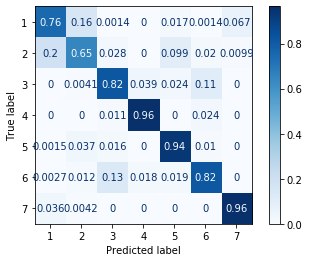


Model: LGBMClassifier
	cv acc: 0.872
	split acc: 0.8533
	time taken: 54.332
	 [0.7571  0.67801 0.82632 0.96078 0.93851 0.85014 0.96353]


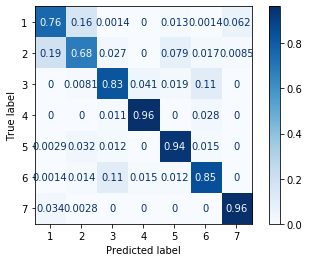


Model: LGBMClassifier
	cv acc: 0.8748
	split acc: 0.8587
	time taken: 55.3953
	 [0.76136 0.68794 0.83718 0.95938 0.94436 0.85967 0.96213]


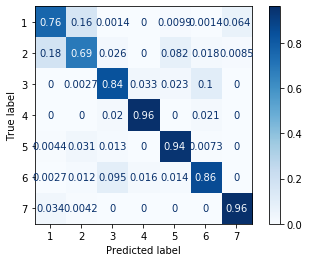


Model: LGBMClassifier
	cv acc: 0.8858
	split acc: 0.8691
	time taken: 60.1594
	 [0.76847 0.67234 0.87246 0.96639 0.95461 0.87602 0.97335]


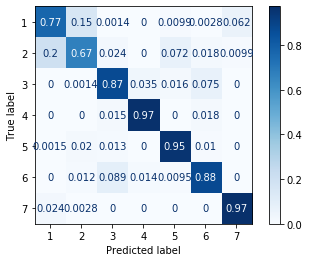

In [12]:
for i in range(0,4):
    lgbz = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt', max_depth=8, num_leaves=90)
    df_train_norm = pipeline(df_train, version=i)
    score_model(lgbz, df_train_norm)

In [ ]:
df_submit